# Read data

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path


data_dir  = Path('/work/CS221.M11.KHCL-Aspect-Based-Sentiment-Analysis/data/csv')

train_fp  = data_dir/'train.csv'
dev_fp    = data_dir/'dev.csv'
test_fp   = data_dir/'test.csv'


def read_csv(csv_path):
    assert csv_path.is_file()
    df = pd.read_csv(csv_path)

    X = df.pop('review')
    y = df.replace({
        np.nan: 0, 
        'negative': 1, 
        'neutral': 2, 
        'positive': 3}) \
        .astype(np.uint8)

    print('X.shape:', X.shape, 'y.shape:', y.shape, csv_path.name)
    return X, y

X_train, y_train = read_csv(train_fp)
X_dev, y_dev = read_csv(dev_fp)
X_test, y_test = read_csv(test_fp)

X.shape: (2961,) y.shape: (2961, 12) train.csv
X.shape: (1290,) y.shape: (1290, 12) dev.csv
X.shape: (500,) y.shape: (500, 12) test.csv



# EDA

Số nhãn từng lớp trong tập train


<AxesSubplot:>

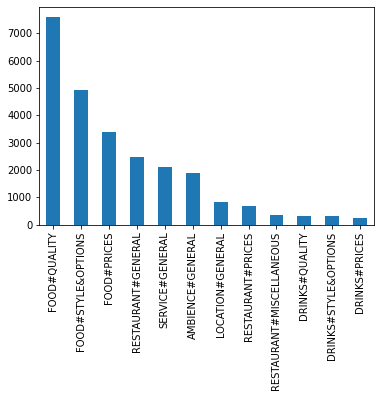

In [ ]:
import matplotlib as plt
print('Số nhãn từng lớp trong tập train')
count_aspects = (~~y_train).sum(axis=0).sort_values(ascending=False)
count_aspects.plot.bar()

# Tiền xử lí dữ liệu

In [ ]:
import re
import emoji
from sklearn.base import BaseEstimator, TransformerMixin


class Preprocessing(BaseEstimator, TransformerMixin):
    def step1(self, X):
        """Thay 100k, 200d thành “giá tiền”. Thay #lozi, #blabla thành hag_tag
        """
        pass

    def step2(self, X):
        """Xóa kí tự đặc biệt
        """
        pass

    def step3(self, X):
        """Tách từ dính liền nhau (vd: "tả dcVới giá") hoặc icon dính với một từ
        """
        emoji_regexp = emoji.get_emoji_regexp()
        return [emoji_regexp.sub('', x) for x in X]

    def step4(self, X):
        """Đổi những từ bị kéo dài thành từ đúng chính tả (ngooon -> ngon)
        """
        pass

    def step5(self, X):
        """đổi các từ phủ định sau: khong, ko, khg, k… thành không
        """
        pass

    def step6(self, X):
        """phân thành token và pos tagging sử dụng thư viện Pyvi
        """
        pass

    def step7(self, X):
        """Loại bỏ tên đồ ăn và thức uống
        """
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return self.step3(X)

# Models

## Model 0 (Random Forest)

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer


model0 = make_pipeline(
    Preprocessing(),
    TfidfVectorizer(),
    RandomForestClassifier()
)

model0.fit(X_train, y_train)

Pipeline(steps=[('preprocessing', Preprocessing()),
                ('tfidfvectorizer', TfidfVectorizer()),
                ('randomforestclassifier', RandomForestClassifier())])

## Model 1

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier


model1 = make_pipeline(
    Preprocessing(),
    TfidfVectorizer(),
    ExtraTreesClassifier()
)

model1.fit(X_train, y_train)

Pipeline(steps=[('preprocessing', Preprocessing()),
                ('tfidfvectorizer', TfidfVectorizer()),
                ('extratreesclassifier', ExtraTreesClassifier())])

## Model 2

In [ ]:
!pip install -q https://gitlab.com/trungtv/vi_spacy/-/raw/master/vi_core_news_lg/dist/vi_core_news_lg-0.0.1.tar.gz

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [ ]:
import spacy

In [ ]:
nlp = spacy.load('vi_core_news_md')

OSError: [E050] Can't find model 'vi_core_news_md'. It doesn't seem to be a Python package or a valid path to a data directory.

In [ ]:
import pyvi

In [ ]:
spacy.__version__

'3.1.3'

# Evaluation

## Custom Evaluation Tool

In [ ]:
from sklearn.metrics import f1_score

def multioutput_to_multilabel(y):
    if isinstance(y, pd.DataFrame): 
        y = y.values
    nrow = y.shape[0]
    ncol = y.shape[1]
    multilabel = np.zeros((nrow, 3 * ncol), dtype=bool)
    for i in range(nrow):
        for j in range(ncol):
            if y[i, j] != 0:
                pos = j * 3 + (y[i, j] - 1)
                multilabel[i, pos] = True
    return multilabel


def custom_f1_score(y_true, y_pred, average='micro', **kwargs):
    y_true = multioutput_to_multilabel(y_true)
    y_pred = multioutput_to_multilabel(y_pred)
    return f1_score(y_true, y_pred, average=average, **kwargs)


def custom_evaluate(model, X, y_true):
    y_pred = model.predict(X)
    return custom_f1_score(y_true, y_pred)

In [ ]:
custom_evaluate(model0, X_dev, y_dev)

0.5808514218408212

In [ ]:
custom_evaluate(model1, X_dev, y_dev)

0.5775273224043715

## Official Evaluation Tool

In [ ]:
import json


sentiments = [None, 'negative', 'neutral', 'positive']

with open(data_dir/'aspects.json') as f:
    aspects = json.load(f)


def label_decoder(encoded_label):
    label = []
    for ap_idx, stm_idx in enumerate(encoded_label):
        if stm_idx != 0:
            aspect = aspects[ap_idx]
            sentiment = sentiments[stm_idx]
            label.append(f'{{{aspect}, {sentiment}}}')

    return ', '.join(label)


def save_result(X, y, save_path):
    rows = []
    for test_id, (review, encoded_label) in enumerate(zip(X, y), 1):
        label = label_decoder(encoded_label)
        rows.extend((f'#{test_id}', review, label, ''))

    text = '\n'.join(rows[:-1])
    with open(save_path, mode='w', encoding='utf-8-sig') as output_file:
        output_file.write(text)

    
def evaluate(model, X, y_true_path, y_pred_path):
    y = model.predict(X)
    save_result(X, y, y_pred_path)
    !java SAEvaluate.java {y_true_path} {y_pred_path}

### Evaluate on dev

In [ ]:
evaluate(model0, X_dev, "/work/y_dev.txt", "/work/y_pred_model0.txt")

Evaluation Result >> File:/work/y_pred_model0.txt<> [/work/y_dev.txt]
                              	asp#1	asp#2	asp#3	asp#4	asp#5	asp#6	asp#7	asp#8	asp#9	asp#10	asp#11	asp#12
                    Gold count	724	1160	516	231	205	228	134	117	44	10	39	35
                  ANSWER count	189	1282	844	21	34	122	1	2	1	0	2	2

        Correct ANSWER: aspect	183	1158	462	12	32	118	1	1	1	0	2	1
             Precision: aspect	0.9683	0.9033	0.5474	0.5714	0.9412	0.9672	1.0000	0.5000	1.0000	0.0000	1.0000	0.5000
                Recall: aspect	0.2528	0.9983	0.8953	0.0519	0.1561	0.5175	0.0075	0.0085	0.0227	0.0000	0.0513	0.0286
              F1 score: aspect	0.4009	0.9484	0.6794	0.0952	0.2678	0.6743	0.0148	0.0168	0.0444	0.0000	0.0976	0.0541
  Over All ANSWER: aspect:----	0.7884	0.5725	0.6633

  Correct ANSWER: aspect,value	145	1032	402	12	28	102	1	0	1	0	2	1
      Precision: aspect, value	0.7672	0.8050	0.4763	0.5714	0.8235	0.8361	1.0000	0.0000	1.0000	0.0000	1.0000	0.5000
         Recall: aspect, value	0.200

In [ ]:
evaluate(model1, X_dev, "/work/y_dev.txt", "/work/y_pred_model1")

Evaluation Result >> File:/work/y_pred_model1<> [/work/y_dev.txt]
                              	asp#1	asp#2	asp#3	asp#4	asp#5	asp#6	asp#7	asp#8	asp#9	asp#10	asp#11	asp#12
                    Gold count	724	1160	516	231	205	228	134	117	44	10	39	35
                  ANSWER count	152	1282	824	19	36	92	1	2	1	0	2	2

        Correct ANSWER: aspect	147	1158	460	15	34	91	1	1	1	0	2	1
             Precision: aspect	0.9671	0.9033	0.5583	0.7895	0.9444	0.9891	1.0000	0.5000	1.0000	0.0000	1.0000	0.5000
                Recall: aspect	0.2030	0.9983	0.8915	0.0649	0.1659	0.3991	0.0075	0.0085	0.0227	0.0000	0.0513	0.0286
              F1 score: aspect	0.3356	0.9484	0.6866	0.1200	0.2822	0.5688	0.0148	0.0168	0.0444	0.0000	0.0976	0.0541
  Over All ANSWER: aspect:----	0.7920	0.5550	0.6527

  Correct ANSWER: aspect,value	121	1035	399	15	30	86	1	0	1	0	2	1
      Precision: aspect, value	0.7961	0.8073	0.4842	0.7895	0.8333	0.9348	1.0000	0.0000	1.0000	0.0000	1.0000	0.5000
         Recall: aspect, value	0.1671	0.892

### Evaluate on test

# Code nháp gõ dưới đây

In [ ]:
remove_emoji(['hôm nay trời đẹp 🙂', 'hôm nay mưa lớn 🌧'])

array(['hôm nay trời đẹp ', 'hôm nay mưa lớn '], dtype='<U17')

In [ ]:
import re
import numpy as np
def transform_units(texts):
    """List comprehension"""
    return np.array([re.sub(r"\d+[$,d,k,₫]","giá tiền",text) for text in texts])
        

In [ ]:
# tmp123 = r'Cập Nhật Giá : 1/12/2015 🐸 - Phần 1 con + cháo => 35.000₫ - Phần 2 con + cháo => 70.000₫ - Phần 3 con + cháo => 90.000₫* Có " Nước Sâm ( 5k ) , Nước ngọt ( tuỳ loại ) , Trà Đá ( 2k )🎀 Quán lề đường, sạch sẽ, nấu ếch tại chỗ cho khách xem. Nhưng phụ vụ hơi lâu, gọi tính tiền cũng lâu nữa 😞 🎀 Ăn được . Ngon !'
transform_units(['giá món ăn này mắc thế tới 200k lận',
                 'bán 12.000 vnd',
                 'mua 30.000.000vnd'
                 tmp123])
        

array(['giá món ăn này mắc thế tới giá tiền lận',
       'Cập Nhật Giá : 1/12/2015 🐸 - Phần 1 con + cháo => 35.giá tiền - Phần 2 con + cháo => 70.giá tiền - Phần 3 con + cháo => 90.giá tiền* Có " Nước Sâm ( giá tiền ) , Nước ngọt ( tuỳ loại ) , Trà Đá ( giá tiền )🎀 Quán lề đường, sạch sẽ, nấu ếch tại chỗ cho khách xem. Nhưng phụ vụ hơi lâu, gọi tính tiền cũng lâu nữa 😞 🎀 Ăn được . Ngon !'],
      dtype='<U332')

In [ ]:
import re
import numpy as np
def transform_units_123(texts):
    return np.array([re.sub(r"[_@!#$&^*%<>?/=+`]",'',text) for text in texts])

In [ ]:
transform_units_123(['@ hên quá đi=, hôm nay cô không khảo bài ^'])

array([' hên quá đi, hôm nay cô không khảo bài '], dtype='<U39')

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=b5b5c153-f56a-4329-a053-06afe7378c69' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>